In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import plotly.plotly as plotly
from plotly.graph_objs import *
import numpy as np
%load_ext autoreload
%autoreload 2
from model_defs import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#  Make notebook and pandas DataFrames look better
from IPython.core.display import HTML
css = open("../styles/style-table.css").read() + open('../styles/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

# List of trials to run

* various percentages of:
    * Yours Network Payout
    * Content Provider Payout
    * Curation Payout
* Time models:
    * Immediate viral and sizzle
    * slow and steady promotion
    * future event promotion
* Curration distributions:
    * mixed normal with outliars
    * mixed normal without outliars
    * high initial seeding

In [5]:
max_tip = 5
num_tips = 100
curator_perc = 0.9
yours_perc = 0.1
df = get_payouts_uniform(max_tip=max_tip, num_tips=num_tips, curator_payout_perc=curator_perc, yours_payout_perc=yours_perc)
df.head()

Total tipped:    $262.59
Yours revenue:   $26.26
Creator revenue: $2.58
Curator revenue: $233.75


,tip,curator_payouts,yours_revenue,curator_num,total_earned
0,2.86148,"[4.20033787461, 0.451699322674, 1.36878367522,...",0.286148,0,13.951702
1,4.66704,"[0.736716403758, 2.23247044242, 0.203136577347...",0.466704,1,15.904363
2,1.32046,"[0.631640373172, 0.0574741152592, 0.2560987337...",0.132046,2,4.291433
3,4.70322,"[0.204711079157, 0.91217146935, 0.281715260123...",0.470322,3,13.035436
4,0.655411,"[0.127114555087, 0.0392580903429, 0.0330512265...",0.0655411,4,1.788010


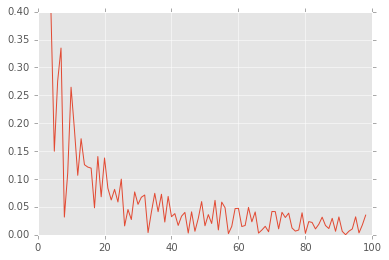

In [7]:
# Plot the payout of a given curator
curator_num = 5
plt.plot(df.curator_num[(curator_num-1):-1], df.curator_payouts[curator_num-1])

Total tipped:    $78.82
Yours revenue:   $7.88
Creator revenue: $0.59
Curator revenue: $70.36


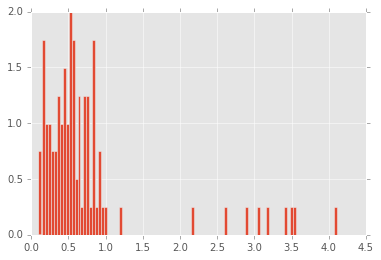

In [29]:
tip_amounts = [0.25, 0.50, 0.75, 3.0]
num_tips = 100
curator_perc = 0.9
yours_perc = 0.1
df = get_payouts_mixed_normal(tip_amounts, num_tips, curator_perc, yours_perc)
plt.hist(df_normal.tip, 100, normed=True)
plt.show()

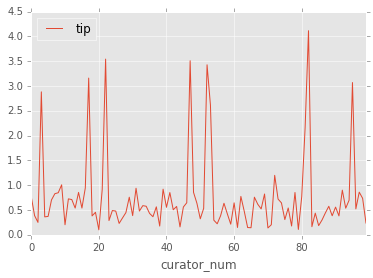

In [28]:
df.plot(x='curator_num', y='tip')

In [30]:
sizemode='area'
sizeref = df['total_earned'].max() / 1e2**1.5
labels = []
for exact in df['total_earned']:
    labels.append('${0:.2f}'.format(round(exact,2)))
df['labels'] = labels
df['recouped'] = df.total_earned > df.tip     # for separating Da

colors = dict(
    yes='#ff7f0e',     # color for profiting curator
    no='#2ca02c',      # color for non-profiting curator
)    

# Define a trace-generating function (returns a Scatter object)
def make_trace(X, recouped, sizes, color):
    return Scatter(
        x=X['curator_num'],              # Curator number
        y=X['tip'],                      # Amount of initial tip
        text=X['labels'],                      # label on hover
        mode='markers',                   # (!) point markers only on this plot
        name=recouped,
        marker= Marker(       
            size=sizes,          # (!) marker sizes (sizes is a list)
            color=color,
            sizeref=sizeref,              # link sizeref
            sizemode=sizemode,            # link sizemode
            opacity=0.5,                  # (!) partly transparent markers
            line=Line(width=0.0)          # remove marker borders
        )
    )

def make_annote_list(string, xpos, ypos):
    return dict(
        x=xpos,
        y=ypos,
        xref='x',
        yref='y',
        text=string,
        showarrow=False,
        font=Font(size=12),   # increase font size (default is 12)
#         bgcolor='#FFFFFF',    # white background
#         borderpad=4           # set border/text space (in pixels)
    )
# Make Annotation text
annote_list = []        
strings = [
    'Total tipped:    ${0:.2f}'.format(round(df.tip.sum()), 2),
    'Creator revenue: ${0:.2f}'.format(round(df.tip[1:].sum() * (1 - (yours_perc + curator_perc))
                                                   + df.tip[0] * (1 - yours_perc), 2)),
    'Curator revenue: ${0:.2f}'.format(round(df.total_earned.sum(), 2)),
    'Yours revenue:   ${0:.2f}'.format(round(df.yours_revenue.sum(), 2)),
    ]
xs = [num_tips, num_tips, num_tips, num_tips]
ys = [max_tip+4, max_tip+3, max_tip+2, max_tip+1]
for string, x, y in zip(strings, xs, ys):
    annote_list.append(make_annote_list(string, x, y))
    
data = Data()
for recouped, X in df.groupby('recouped'):

    sizes = X['total_earned']                  # get population array 
    if recouped:                               # get bubble color
        color=colors['yes']
        recouped = 'Profited'
    else:
        color=colors['no']
        recouped = "Didn't profit"

    data.append(
        make_trace(X, recouped, sizes, color)  # append trace to data object
    )


# Set plot and axis titles
title = "Projected Yours Network Payout"
x_title = "Curator Number"
y_title = "Amount Tipped, (USD)"

# Define a dictionary of axis style options
axis_style = dict(
    zeroline=False,       # remove thick zero line
    gridcolor='#FFFFFF',  # white grid lines
    ticks='outside',      # draw ticks outside axes 
    ticklen=8,            # tick length
    tickwidth=1.5,        #   and width
)

# Make layout object
layout = Layout(
    title=title,             # set plot title
    plot_bgcolor='#EFECEA',  # set plot color to grey
    hovermode='closest',     # set hover to show closest to cursor
    xaxis=XAxis(
        axis_style,      # add axis style dictionary
        title=x_title,   # x-axis title
    ),
    yaxis=YAxis(
        axis_style,      # add axis style dictionary
        title=y_title,   # y-axis title
    ),
    showlegend=False,     # remove legend (info in hover)
    autosize=False,       # turn off autosize
    annotations=annote_list
)

# Make Figure object
fig = Figure(data=data, layout=layout)

# (@) Send to Plotly and show in notebook
plotly.iplot(fig, filename='Yours_plots/paymentModel-90-mixedNormal')